In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

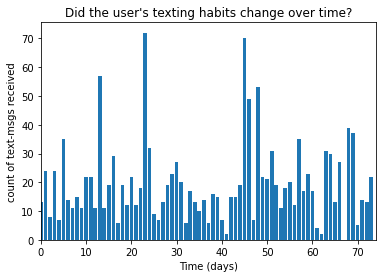

In [2]:
count_data = np.loadtxt('data/txtdata.csv')
n_count_data = len(count_data)

plt.bar(np.arange(n_count_data), count_data)
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data);
plt.show()

## Prior

In [3]:
alpha = 1.0 / count_data.mean()
idx = np.arange(n_count_data)

with pm.Model() as model:
    tau = pm.DiscreteUniform('tau', lower=0, upper=n_count_data)

    lambda_1 = pm.Exponential('lambda_1', alpha)
    lambda_2 = pm.Exponential('lambda_2', alpha)
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

In [4]:
with model:
    observation = pm.Poisson('obs', lambda_, observed=count_data)

## Posterior

In [5]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(15000, tune=5000, step=step, return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
>Metropolis: [tau]


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 16 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [6]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

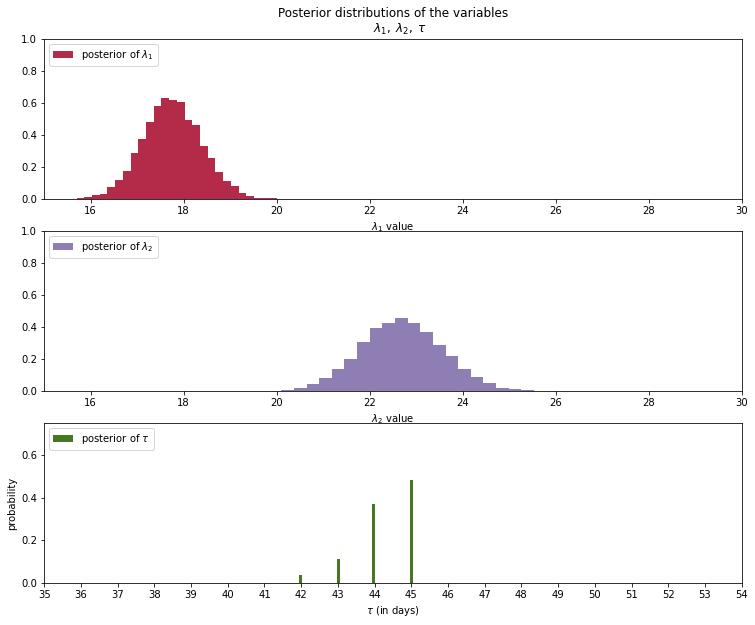

In [7]:
plt.figure(figsize=(12.5, 10))
ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

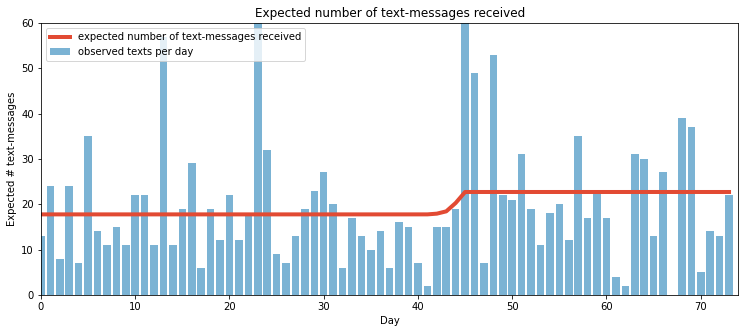

In [17]:
plt.figure(figsize=(12.5, 5))

N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)

for day in range(0, n_count_data):
    idx = day < tau_samples
    expected_texts_per_day[day] = (lambda_1_samples[idx].sum() + lambda_2_samples[~idx].sum()) / N

plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");

In [19]:
print(lambda_1_samples.mean())
print(lambda_2_samples.mean())

17.753069309212123
22.695832664025737
